### Imports & Transforms & Paths

In [20]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
from PIL import Image
import seaborn as sns
import warnings
from statsmodels.stats.proportion import proportion_confint

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
filtered_train_neutral_dir = "./ROF/images/filtered_neutral_train"
filtered_test_neutral_dir = "./ROF/images/filtered_neutral_test"
filtered_masked_dir = "./ROF/images/filtered_masked"
filtered_sunglasses_dir = "./ROF/images/filtered_sunglasses"

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
with open("selected_people.txt", "r") as f:
    selected_people = [line.strip() for line in f.readlines()]

### Dataset & DataLoader

In [21]:
batch_size = 64

train_data = datasets.ImageFolder(filtered_train_neutral_dir, transform=transform)
test_data = datasets.ImageFolder(filtered_test_neutral_dir, transform=transform)
masked_data = datasets.ImageFolder(filtered_masked_dir, transform=transform)
sunglasses_data = datasets.ImageFolder(filtered_sunglasses_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)
masked_loader = DataLoader(masked_data, batch_size=batch_size)
sunglasses_loader = DataLoader(sunglasses_data, batch_size=batch_size)

num_classes = len(selected_people)

### Model Train Function

In [22]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, save_path="best_resnet50.pth"):
    best_acc = 0.0
    accuracy_train_neutral = []
    accuracy_test_neutral = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                preds = outputs.argmax(dim=1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total

        accuracy_train_neutral.append(train_acc)
        accuracy_test_neutral.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), save_path)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Test Acc: {test_acc:.4f}")

    print("Training complete. Best Test Accuracy:", best_acc)
    
    return accuracy_train_neutral, accuracy_test_neutral

### Model Eval Function

In [31]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total

    return accuracy, correct, total

def compute_confidence_interval(correct, total, confidence=0.95):
    lower, upper = proportion_confint(correct, total, alpha=0.05, method='wilson')
    return lower, upper

### ResNet18 Model

In [ ]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

##### Neutral Training/Testing

In [22]:
accuracy_train_neutral, accuracy_test_neutral = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10,  # Or whatever number you want
    save_path="best_resnet18.pth"  # Or a custom name
)

Epoch 1/10 | Train Loss: 3.0044 | Train Acc: 0.0939 | Test Acc: 0.1579
Epoch 2/10 | Train Loss: 2.5524 | Train Acc: 0.4155 | Test Acc: 0.4298
Epoch 3/10 | Train Loss: 2.2054 | Train Acc: 0.6526 | Test Acc: 0.5263
Epoch 4/10 | Train Loss: 1.8607 | Train Acc: 0.7817 | Test Acc: 0.5702
Epoch 5/10 | Train Loss: 1.5553 | Train Acc: 0.8615 | Test Acc: 0.6140
Epoch 6/10 | Train Loss: 1.2048 | Train Acc: 0.8991 | Test Acc: 0.6842
Epoch 7/10 | Train Loss: 0.9531 | Train Acc: 0.9319 | Test Acc: 0.7719
Epoch 8/10 | Train Loss: 0.7040 | Train Acc: 0.9577 | Test Acc: 0.7982
Epoch 9/10 | Train Loss: 0.4854 | Train Acc: 0.9742 | Test Acc: 0.7982
Epoch 10/10 | Train Loss: 0.3539 | Train Acc: 0.9812 | Test Acc: 0.8070
Training complete. Best Test Accuracy: 0.8070175438596491


##### Output

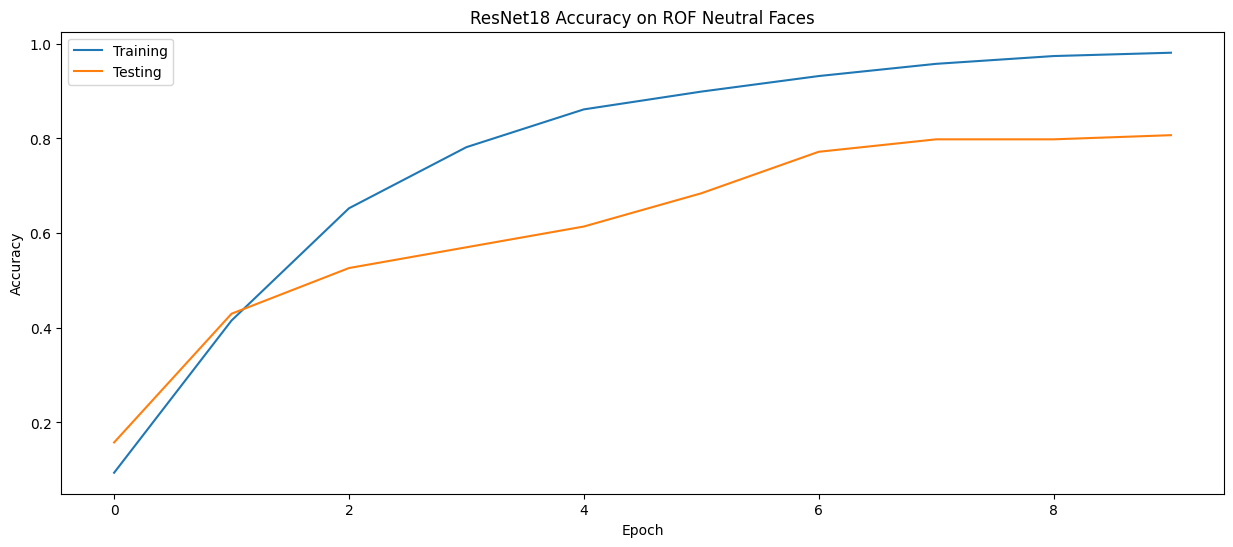

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(accuracy_train_neutral, label='Training')
ax.plot(accuracy_test_neutral, label='Testing')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set_title('ResNet18 Accuracy on ROF Neutral Faces')
ax.legend()
plt.show()

##### Occlusion Testing

In [ ]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

# Load saved trained model
model.load_state_dict(torch.load("best_resnet18.pth"))
model.eval()

In [25]:
print(f"Masked Test Accuracy: {evaluate(model, masked_loader):.4f}")
print(f"Sunglasses Test Accuracy: {evaluate(model, sunglasses_loader):.4f}")

Masked Test Accuracy: 0.3500
Sunglasses Test Accuracy: 0.2825


### ResNet50 Model

In [ ]:
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

##### Neutral Training/Testing

In [7]:
accuracy_train_neutral, accuracy_test_neutral = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10,  # Or whatever number you want
    save_path="best_resnet50.pth"  # Or a custom name
)

Epoch 1/10 | Train Loss: 2.9586 | Train Acc: 0.1009 | Test Acc: 0.1491
Epoch 2/10 | Train Loss: 2.6168 | Train Acc: 0.4038 | Test Acc: 0.3158
Epoch 3/10 | Train Loss: 2.2437 | Train Acc: 0.5986 | Test Acc: 0.4649
Epoch 4/10 | Train Loss: 1.7848 | Train Acc: 0.7418 | Test Acc: 0.5263
Epoch 5/10 | Train Loss: 1.3558 | Train Acc: 0.8662 | Test Acc: 0.6667
Epoch 6/10 | Train Loss: 0.8930 | Train Acc: 0.9366 | Test Acc: 0.7982
Epoch 7/10 | Train Loss: 0.5218 | Train Acc: 0.9695 | Test Acc: 0.7895
Epoch 8/10 | Train Loss: 0.3167 | Train Acc: 0.9718 | Test Acc: 0.8158
Epoch 9/10 | Train Loss: 0.1806 | Train Acc: 0.9695 | Test Acc: 0.8421
Epoch 10/10 | Train Loss: 0.1471 | Train Acc: 0.9812 | Test Acc: 0.8509
Training complete. Best Test Accuracy: 0.8508771929824561


##### Output

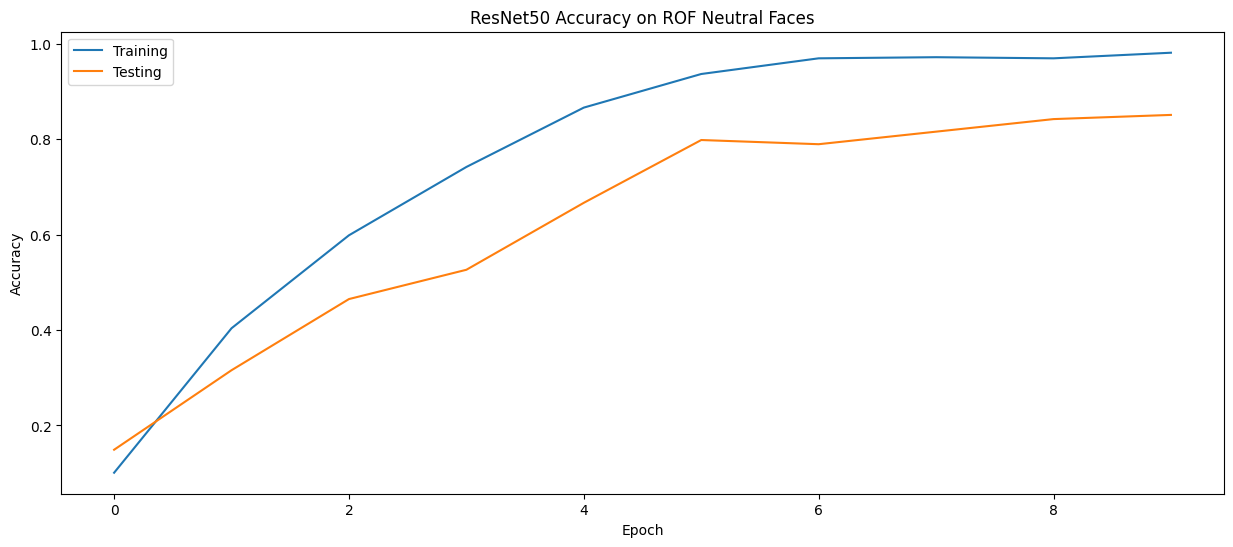

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(accuracy_train_neutral, label='Training')
ax.plot(accuracy_test_neutral, label='Testing')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set_title('ResNet50 Accuracy on ROF Neutral Faces')
ax.legend()
plt.show()

##### Occlusion Testing

In [12]:
model = models.resnet50(pretrained=True).to(device)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

# Load saved trained model
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

In [20]:
print(f"Masked Test Accuracy: {evaluate(model, masked_loader):.4f}")
print(f"Sunglasses Test Accuracy: {evaluate(model, sunglasses_loader):.4f}")

Masked Test Accuracy: 0.4250
Sunglasses Test Accuracy: 0.2768


### Lateral Inhibition/Excitation Model

In [24]:
class LateralInhibitionLayer(nn.Module):
    def __init__(self, excitation_strength=1.0, inhibition_strength=-0.5, use_skip=True):
        super().__init__()
        self.use_skip = use_skip

        # Initialize kernel with excitation center + inhibition surround
        kernel = torch.tensor([
            [inhibition_strength, inhibition_strength, inhibition_strength],
            [inhibition_strength, excitation_strength, inhibition_strength],
            [inhibition_strength, inhibition_strength, inhibition_strength]
        ], dtype=torch.float32)

        self.weight = nn.Parameter(
            kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1),
            requires_grad=False
        )

    def forward(self, x):
        filtered = F.conv2d(x, self.weight, padding=1, groups=3)
        filtered = F.relu(filtered)  # Remove negative responses (biological realism)

        return x + filtered if self.use_skip else filtered


In [25]:
class InhibitedResNet(nn.Module):
    def __init__(self, excitation_strength, inhibition_strength, num_classes, resnet_type="resnet50"):
        super().__init__()
        self.inhibition = LateralInhibitionLayer(excitation_strength, inhibition_strength)

        if resnet_type == "resnet50":
            self.resnet = models.resnet50(pretrained=True)
        elif resnet_type == "resnet18":
            self.resnet = models.resnet18(pretrained=True)
        else:
            raise ValueError("Invalid resnet_type")

        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.inhibition(x)
        x = self.resnet(x)
        return x


##### Neutral Training/Testing

In [9]:
excitation_vals = [0.8, 1.0, 1.2, 2.0]     # 2.0 = hyperexcitation
inhibition_vals = [-0.1, -0.3, -0.5, -2.0] # -2.0 = extreme inhibition

results = {}

for resnet_type in ["resnet50", "resnet18"]:
    for exc in excitation_vals:
        for inh in inhibition_vals:
            print(f"Training {resnet_type.upper()} with Exc: {exc}, Inh: {inh}")

            model = InhibitedResNet(
                excitation_strength=exc,
                inhibition_strength=inh,
                num_classes=num_classes,
                resnet_type=resnet_type
            ).to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
            criterion = nn.CrossEntropyLoss()

            save_name = f"{resnet_type}_exc{exc}_inh{inh}.pth"

            acc_train, acc_val = train_model(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                optimizer=optimizer,
                criterion=criterion,
                device=device,
                num_epochs=10,
                save_path=save_name
            )

            results[(resnet_type, exc, inh)] = {
                "train_acc": acc_train[-1],
                "neutral_test_acc": acc_val[-1]
            }

Training RESNET50 with Exc: 0.8, Inh: -0.1
Epoch 1/10 | Train Loss: 2.9571 | Train Acc: 0.0939 | Test Acc: 0.2105
Epoch 2/10 | Train Loss: 2.6565 | Train Acc: 0.4202 | Test Acc: 0.4123
Epoch 3/10 | Train Loss: 2.2754 | Train Acc: 0.6103 | Test Acc: 0.5088
Epoch 4/10 | Train Loss: 1.8527 | Train Acc: 0.7394 | Test Acc: 0.5351
Epoch 5/10 | Train Loss: 1.3896 | Train Acc: 0.8192 | Test Acc: 0.6316
Epoch 6/10 | Train Loss: 0.9811 | Train Acc: 0.9014 | Test Acc: 0.7193
Epoch 7/10 | Train Loss: 0.6200 | Train Acc: 0.9554 | Test Acc: 0.7719
Epoch 8/10 | Train Loss: 0.3662 | Train Acc: 0.9695 | Test Acc: 0.8158
Epoch 9/10 | Train Loss: 0.2236 | Train Acc: 0.9742 | Test Acc: 0.8246
Epoch 10/10 | Train Loss: 0.1615 | Train Acc: 0.9765 | Test Acc: 0.8158
Training complete. Best Test Accuracy: 0.8245614035087719
Training RESNET50 with Exc: 0.8, Inh: -0.3
Epoch 1/10 | Train Loss: 2.9819 | Train Acc: 0.0775 | Test Acc: 0.2105
Epoch 2/10 | Train Loss: 2.6721 | Train Acc: 0.4178 | Test Acc: 0.3596
Epo

##### Output

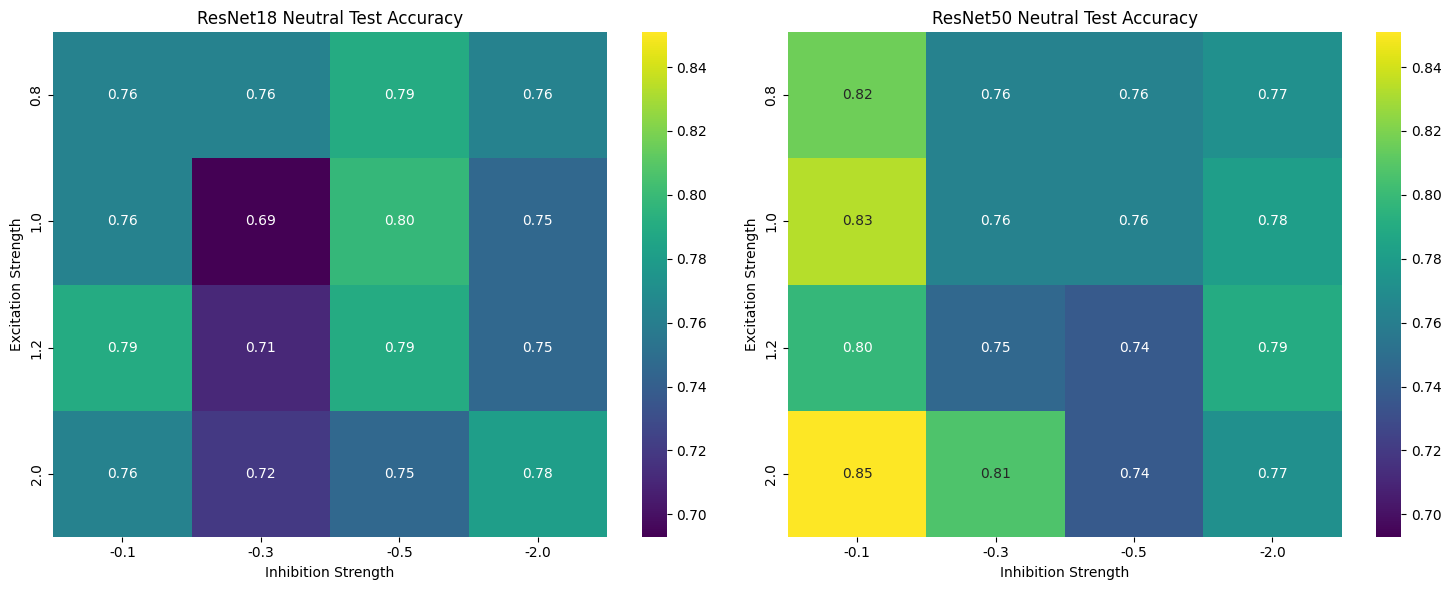

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Prepare matrices
acc_matrix_resnet50 = np.zeros((len(excitation_vals), len(inhibition_vals)))
acc_matrix_resnet18 = np.zeros((len(excitation_vals), len(inhibition_vals)))

for i, exc in enumerate(excitation_vals):
    for j, inh in enumerate(inhibition_vals):
        acc_matrix_resnet50[i, j] = results[("resnet50", exc, inh)]["neutral_test_acc"]
        acc_matrix_resnet18[i, j] = results[("resnet18", exc, inh)]["neutral_test_acc"]

# Global min/max for shared color scale
vmin = min(acc_matrix_resnet50.min(), acc_matrix_resnet18.min())
vmax = max(acc_matrix_resnet50.max(), acc_matrix_resnet18.max())

# ResNet18 Heatmap
sns.heatmap(acc_matrix_resnet18, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals,
            ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title("ResNet18 Neutral Test Accuracy")
axes[0].set_xlabel("Inhibition Strength")
axes[0].set_ylabel("Excitation Strength")

# ResNet50 Heatmap
sns.heatmap(acc_matrix_resnet50, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals,
            ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title("ResNet50 Neutral Test Accuracy")
axes[1].set_xlabel("Inhibition Strength")
axes[1].set_ylabel("Excitation Strength")

plt.tight_layout()
plt.show()

##### Occlusion Testing

In [32]:
# Store occlusion results for both models
occlusion_results = {}

for resnet_type in ["resnet50", "resnet18"]:
    for exc in excitation_vals:
        for inh in inhibition_vals:
            print(f"Evaluating {resnet_type.upper()} | Exc: {exc}, Inh: {inh}")

            # Load trained model with matching inhibition layer
            model = InhibitedResNet(
                excitation_strength=exc,
                inhibition_strength=inh,
                num_classes=num_classes,
                resnet_type=resnet_type
            ).to(device)

            model.load_state_dict(torch.load(f"{resnet_type}_exc{exc}_inh{inh}.pth"))
            model.eval()

            acc_masked, correct_masked, total_masked = evaluate(model, masked_loader)
            acc_sunglasses, correct_sunglasses, total_sunglasses = evaluate(model, sunglasses_loader)
            
            ci_masked = compute_confidence_interval(correct_masked, total_masked)
            ci_sunglasses = compute_confidence_interval(correct_sunglasses, total_sunglasses)


            print(f"  Masked Acc:     {acc_masked:.4f}")
            print(f"  Sunglasses Acc: {acc_sunglasses:.4f}")

            occlusion_results[(resnet_type, exc, inh)] = {
                "masked": {
                    "accuracy": acc_masked,
                    "ci": ci_masked
                },
                "sunglasses": {
                    "accuracy": acc_sunglasses,
                    "ci": ci_sunglasses
                }
            }


Evaluating RESNET50 | Exc: 0.8, Inh: -0.1
  Masked Acc:     0.4083
  Sunglasses Acc: 0.2655
Evaluating RESNET50 | Exc: 0.8, Inh: -0.3
  Masked Acc:     0.2750
  Sunglasses Acc: 0.3616
Evaluating RESNET50 | Exc: 0.8, Inh: -0.5
  Masked Acc:     0.4083
  Sunglasses Acc: 0.2599
Evaluating RESNET50 | Exc: 0.8, Inh: -2.0
  Masked Acc:     0.4417
  Sunglasses Acc: 0.3107
Evaluating RESNET50 | Exc: 1.0, Inh: -0.1
  Masked Acc:     0.3250
  Sunglasses Acc: 0.3785
Evaluating RESNET50 | Exc: 1.0, Inh: -0.3
  Masked Acc:     0.3250
  Sunglasses Acc: 0.2712
Evaluating RESNET50 | Exc: 1.0, Inh: -0.5
  Masked Acc:     0.4167
  Sunglasses Acc: 0.2599
Evaluating RESNET50 | Exc: 1.0, Inh: -2.0
  Masked Acc:     0.3917
  Sunglasses Acc: 0.2938
Evaluating RESNET50 | Exc: 1.2, Inh: -0.1
  Masked Acc:     0.5417
  Sunglasses Acc: 0.3164
Evaluating RESNET50 | Exc: 1.2, Inh: -0.3
  Masked Acc:     0.4083
  Sunglasses Acc: 0.3220
Evaluating RESNET50 | Exc: 1.2, Inh: -0.5
  Masked Acc:     0.4833
  Sunglasses 

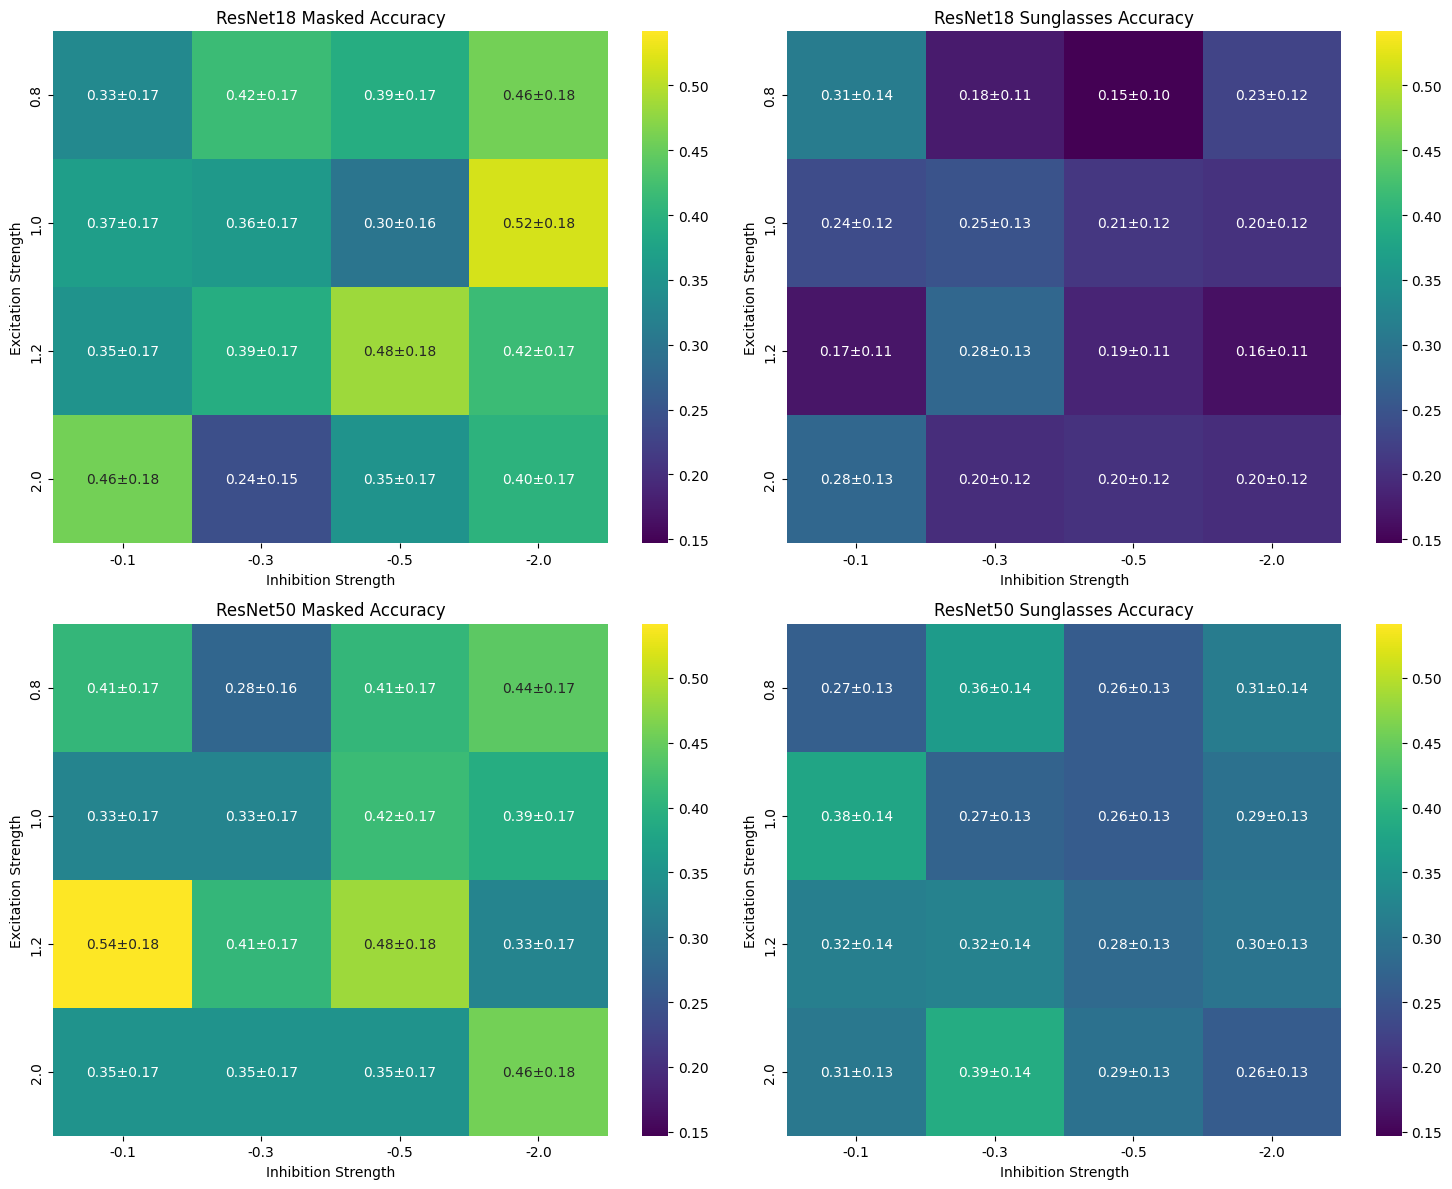

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Helper to create matrix of accuracy values + annotation strings
def create_acc_and_annot_matrix(resnet_type, occlusion_type):
    acc_matrix = np.zeros((len(excitation_vals), len(inhibition_vals)))
    annot_matrix = np.empty((len(excitation_vals), len(inhibition_vals)), dtype=object)
    
    for i, exc in enumerate(excitation_vals):
        for j, inh in enumerate(inhibition_vals):
            acc = occlusion_results[(resnet_type, exc, inh)][occlusion_type]["accuracy"]
            ci = occlusion_results[(resnet_type, exc, inh)][occlusion_type]["ci"]
            
            # If ci is a tuple (lower, upper), get range:
            ci_range = ci[1] - ci[0] if isinstance(ci, tuple) else ci
            
            acc_matrix[i, j] = acc
            annot_matrix[i, j] = f"{acc:.2f}±{ci_range:.2f}"
    
    return acc_matrix, annot_matrix


# Generate matrices for ResNet18
acc_18_masked, annot_18_masked = create_acc_and_annot_matrix("resnet18", "masked")
acc_18_sunglasses, annot_18_sunglasses = create_acc_and_annot_matrix("resnet18", "sunglasses")

# Generate matrices for ResNet50
acc_50_masked, annot_50_masked = create_acc_and_annot_matrix("resnet50", "masked")
acc_50_sunglasses, annot_50_sunglasses = create_acc_and_annot_matrix("resnet50", "sunglasses")

# Global min/max for color scaling
vmin = min(acc_18_masked.min(), acc_18_sunglasses.min(), acc_50_masked.min(), acc_50_sunglasses.min())
vmax = max(acc_18_masked.max(), acc_18_sunglasses.max(), acc_50_masked.max(), acc_50_sunglasses.max())


# Plot ResNet18 Heatmaps
sns.heatmap(acc_18_masked, annot=annot_18_masked, fmt="", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals, ax=axes[0, 0],
            vmin=vmin, vmax=vmax)
axes[0, 0].set_title("ResNet18 Masked Accuracy")
axes[0, 0].set_xlabel("Inhibition Strength")
axes[0, 0].set_ylabel("Excitation Strength")

sns.heatmap(acc_18_sunglasses, annot=annot_18_sunglasses, fmt="", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals, ax=axes[0, 1],
            vmin=vmin, vmax=vmax)
axes[0, 1].set_title("ResNet18 Sunglasses Accuracy")
axes[0, 1].set_xlabel("Inhibition Strength")
axes[0, 1].set_ylabel("Excitation Strength")

# Plot ResNet50 Heatmaps
sns.heatmap(acc_50_masked, annot=annot_50_masked, fmt="", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals, ax=axes[1, 0],
            vmin=vmin, vmax=vmax)
axes[1, 0].set_title("ResNet50 Masked Accuracy")
axes[1, 0].set_xlabel("Inhibition Strength")
axes[1, 0].set_ylabel("Excitation Strength")

sns.heatmap(acc_50_sunglasses, annot=annot_50_sunglasses, fmt="", cmap="viridis",
            xticklabels=inhibition_vals, yticklabels=excitation_vals, ax=axes[1, 1],
            vmin=vmin, vmax=vmax)
axes[1, 1].set_title("ResNet50 Sunglasses Accuracy")
axes[1, 1].set_xlabel("Inhibition Strength")
axes[1, 1].set_ylabel("Excitation Strength")


plt.tight_layout()
plt.show()